In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [11]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [13]:
tokens = tokenizer.encode('This is absolute garbage, noway Im comming back', return_tensors='pt')

In [14]:
tokens

tensor([[  101, 10372, 10127, 35925, 15406, 66395,   117, 30211, 10158, 10205,
         10241, 18120, 11677,   102]])

In [17]:
tokenizer.decode(tokens[0])

'[CLS] this is absolute garbage, noway im comming back [SEP]'

In [19]:
result = model(tokens)

In [20]:
result

SequenceClassifierOutput(loss=None, logits=tensor([[ 5.2447,  1.5618, -0.8826, -2.7557, -2.2617]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [22]:
result.logits

tensor([[ 5.2447,  1.5618, -0.8826, -2.7557, -2.2617]],
       grad_fn=<AddmmBackward0>)

# To get the sentiment score

In [24]:
int(torch.argmax(result.logits)) + 1

1

# Scrapping reviews

In [56]:
# r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont')
# soup = BeautifulSoup(r.text, 'html.parser')
# regex = re.compile('.*comment.*')
# results = soup.find_all('p', {'class':regex})
# reviews = [result.text for result in results]

base_url = 'https://www.yelp.com/biz/social-brew-cafe-pyrmont'
reviews = []

for page_num in range(0, 150, 10):  # Scraping reviews from first 3 pages, change the range as needed
    url = f'{base_url}?start={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    regex = re.compile('.*comment.*')
    results = soup.find_all('p', {'class': regex})
    reviews.extend([result.text for result in results])

# Creating a dataframe

In [58]:
import pandas as pd
import numpy as np

In [59]:
df = pd.DataFrame(np.array(reviews), columns=['reviews'])

In [60]:
df

,reviews
0,Good coffee and toasts. Straight up and down -...
1,Staying in Sydney for work and a work mate and...
2,This cafe is one of the most popular cafes whe...
3,I am a fan! The deciding factor in going here ...
4,Rainy day in Sydney. Borrowed an umbrella and ...
...,...
110,Conveniently located opposite the convention c...
111,I came here on a Sunday at 11am and unfortunat...
112,Menu looks amazing just steer clear of the bee...
113,A very lovely cafe. Staff are very friendly. C...


In [61]:
df['reviews'].iloc[0]

'Good coffee and toasts. Straight up and down - hits the spot with nothing mind blowing. Solid and tasty.  Good work'

# Function to caculate the sentiment score for each review

In [62]:
def sentiment_score(review):
  tokens = tokenizer.encode(review, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits) + 1)

# Adding the sentiment column

In [63]:
df['sentiment'] = df['reviews'].apply(lambda x: sentiment_score(x[:1000]))

In [64]:
df

,reviews,sentiment
0,Good coffee and toasts. Straight up and down -...,5
1,Staying in Sydney for work and a work mate and...,4
2,This cafe is one of the most popular cafes whe...,5
3,I am a fan! The deciding factor in going here ...,5
4,Rainy day in Sydney. Borrowed an umbrella and ...,5
...,...,...
110,Conveniently located opposite the convention c...,4
111,I came here on a Sunday at 11am and unfortunat...,2
112,Menu looks amazing just steer clear of the bee...,4
113,A very lovely cafe. Staff are very friendly. C...,4


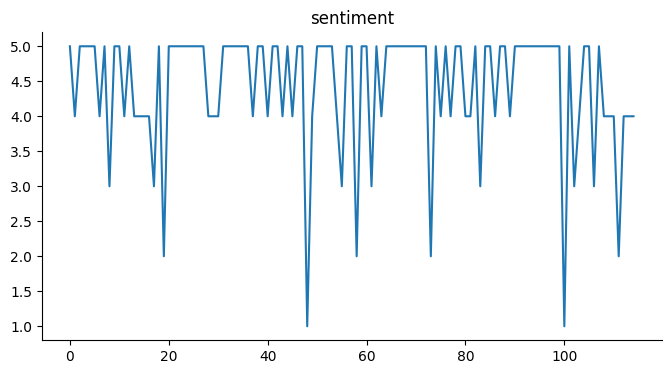

In [65]:
from matplotlib import pyplot as plt
df['sentiment'].plot(kind='line', figsize=(8, 4), title='sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)